In [13]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import numpy as np
from PIL import Image
from config import DEVICE
from torch import nn
import math

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
class Diffusion:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = start_schedule
        self.timesteps = timesteps

        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alpha = 1 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alpha, 0)

    def forward_pass(self, x0, t):
        noise = torch.rand_like(x0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alpha_cumprod.sqrt(), t, x0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alpha_cumprod), t, x0.shape)

        mean = sqrt_alphas_cumprod_t.to(DEVICE) * x0.to(DEVICE)
        variance = sqrt_one_minus_alphas_cumprod_t.to(DEVICE) * noise.to(DEVICE)

        return mean + variance, noise.to(DEVICE)
    
    @torch.no_grad()
    def backward_pass(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance
    
    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if 
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
            
        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)
        
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [3]:
IMAGE_SHAPE = (32, 32)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1] 
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

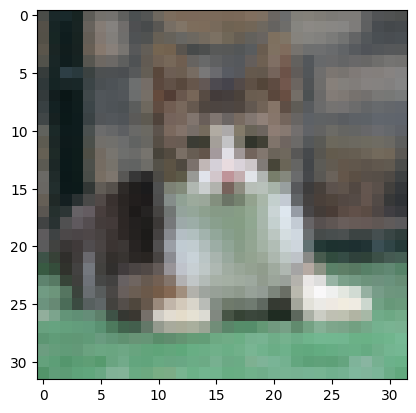

In [4]:
cat = Image.open("cat.jpg")
cat_tensor = transform(cat)
plt.imshow(reverse_transform(cat_tensor))

<Figure size 1500x1500 with 0 Axes>

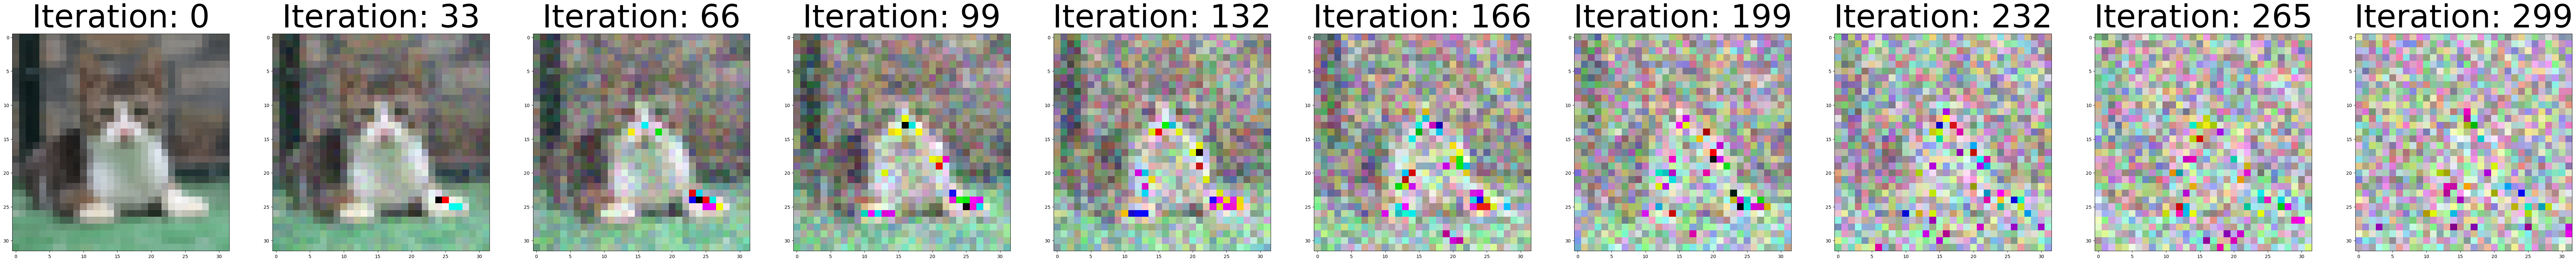

In [5]:
diffusion = Diffusion()

NO_DISPLAY_IMAGES = 10
torch_image_batch = torch.stack([cat_tensor] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion.forward_pass(torch_image_batch, t)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 70)
plt.show()

In [6]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
s_embed = SinusoidalPositionEmbeddings(128)
s_embed(torch.tensor([2,4,6], dtype=torch.float32)).shape

torch.Size([3, 128])

In [7]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
            
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)
    
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

In [72]:
NO_EPOCHS = 2000
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True

unet = UNet(labels=False)
unet.to(DEVICE)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [9]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()


In [10]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [ ]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    
    batch = torch.stack([cat_tensor] * BATCH_SIZE)
    t = torch.randint(0, diffusion.timesteps, (BATCH_SIZE,)).long().to(DEVICE)

    batch_noisy, noise = diffusion.forward_pass(batch, t) 
    predicted_noise = unet(batch_noisy, t)
    
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

In [40]:
from datasets import load_dataset
ds = load_dataset("ylecun/mnist")

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [90]:
from torch.utils.data import Dataset, DataLoader
class mnist_ds(Dataset):
    def __init__(self, pil_list, transform=None):
        super().__init__()
        self.pil_list = pil_list

    def __len__(self):
        return len(self.pil_list)
    
    def __getitem__(self, index):
        pit_image = self.pil_list[index]
        if transform:
            im: torch.tensor = transform(pit_image)
            if im.shape[0] == 1:
                im = im.repeat(3, 1, 1)
        return im

In [91]:
train_ds = mnist_ds(ds['train']['image'], transform=transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

test_ds = mnist_ds(ds['test']['image'], transform=transform)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [ ]:
PRINT_FREQUENCY = 1
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch in train_dl:
        t = torch.randint(0, diffusion.timesteps, (BATCH_SIZE,)).long().to(DEVICE)
        batch = batch.to(DEVICE)
        batch_noisy, noise = diffusion.forward_pass(batch, t) 
        predicted_noise = unet(batch_noisy, t)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    
    for batch in test_dl:
        with torch.no_grad():
            t = torch.randint(0, diffusion.timesteps, (BATCH_SIZE,)).long().to(DEVICE)
            batch = batch.to(DEVICE)

            batch_noisy, noise = diffusion.forward_pass(batch, t) 
            predicted_noise = unet(batch_noisy, t)

            loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
            mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"epoch: {epoch}")